In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

import torch
import torch.nn
import torch.optim
import torch.utils.data

import time
import math

Utility function for seeing what happens when taking gradient of loss function.

In [2]:
def getBack(var_grad_fn):
    print(var_grad_fn)
    for n in var_grad_fn.next_functions:
        if n[0]:
            try:
                tensor = getattr(n[0], 'variable')
                print(n[0])
                print('Tensor with grad found:', tensor)
                print(' - gradient:', tensor.grad)
                print()
            except AttributeError as e:
                getBack(n[0])

Playing around with different activation functions.  We may want a steeply-rising activation for our cut-based
approach.

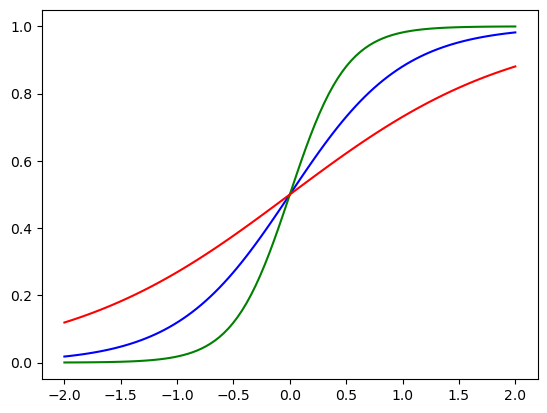

In [3]:
xvals=np.linspace(-2,2,100)

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def tanhx(xvals, scale):
    return ((np.tanh(scale*xvals))+1)/2


plt.plot(xvals,tanhx(xvals, 1.),color="blue")
plt.plot(xvals,tanhx(xvals, 2.),color="green")
plt.plot(xvals,sigmoid(xvals),color="red")
plt.show()

Now let's generate two histograms and play around with separating them.

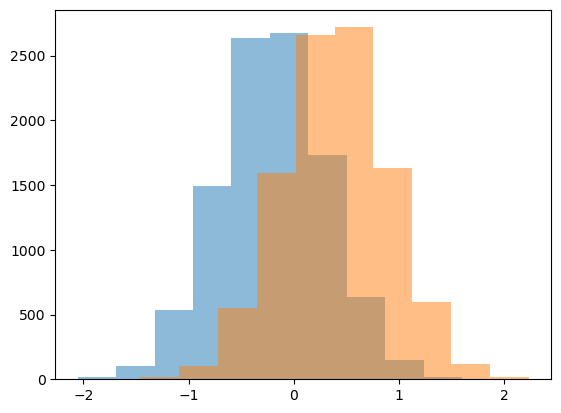

In [4]:
N=10000
x_signal=-0.2+0.5*np.random.randn(N)
y_signal=np.ones(N)
x_backgr=0.4+0.5*np.random.randn(N)
y_backgr=np.zeros(N)
plt.hist(x_signal,alpha=0.5)
plt.hist(x_backgr,alpha=0.5)
plt.show()
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [6]:
sc = StandardScaler()

x_train_scaled = sc.fit_transform(x_train.reshape(-1, 1))
x_test_scaled  = sc.transform(x_test.reshape(-1, 1))

In [7]:
features=1

torch.manual_seed(123)
net = torch.nn.Sequential(
    torch.nn.Linear(features, features)
)
#net[0].weight[0][1] = torch.nn.Parameter(torch.tensor([1.]), requires_grad=False)
#print(net[0].weight)
torch.save(net.state_dict(), 'net.pth')

bce_loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.05)

In [8]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)
y_train_tensor=y_train_tensor.unsqueeze(1)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)
y_test_tensor=y_test_tensor.unsqueeze(1)

In [9]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

if torch.cuda.is_available():
    print("Using GPU")
    device = torch.device("cuda:0")
    # we need to send the network and data to the GPU!
    net.to(device)
    x_train_tensor=x_train_tensor.to(device)
    y_train_tensor=y_train_tensor.to(device)
    x_test_tensor=x_test_tensor.to(device)
    y_test_tensor=y_test_tensor.to(device)

    
xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(y_train)/1), shuffle=True)


for epoch in range(50):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        #print(net[0].bias)
        #print(net[0].weight)
        y_pred = net(x_batch)
        #print(y_pred)
        optimizer.zero_grad()
        loss = bce_loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=bce_loss_fn(y_pred, y_test_tensor)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.3s, Train loss=6.1e-01, Test loss=6.0e-01
Completed epoch  1 in  0.3s, Train loss=6.0e-01, Test loss=6.0e-01
Completed epoch  2 in  0.4s, Train loss=6.0e-01, Test loss=5.9e-01
Completed epoch  3 in  0.3s, Train loss=5.9e-01, Test loss=5.8e-01
Completed epoch  4 in  0.5s, Train loss=5.8e-01, Test loss=5.8e-01
Completed epoch  5 in  0.3s, Train loss=5.8e-01, Test loss=5.7e-01
Completed epoch  6 in  0.5s, Train loss=5.7e-01, Test loss=5.7e-01
Completed epoch  7 in  0.2s, Train loss=5.7e-01, Test loss=5.6e-01
Completed epoch  8 in  0.2s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch  9 in  0.4s, Train loss=5.6e-01, Test loss=5.6e-01
Completed epoch 10 in  0.2s, Train loss=5.6e-01, Test loss=5.5e-01
Completed epoch 11 in  0.4s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 12 in  0.2s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 13 in  0.5s, Train loss=5.5e-01, Test loss=5.5e-01
Completed epoch 14 in  0.3s, Train loss=5.5e-01, Test loss=5.5

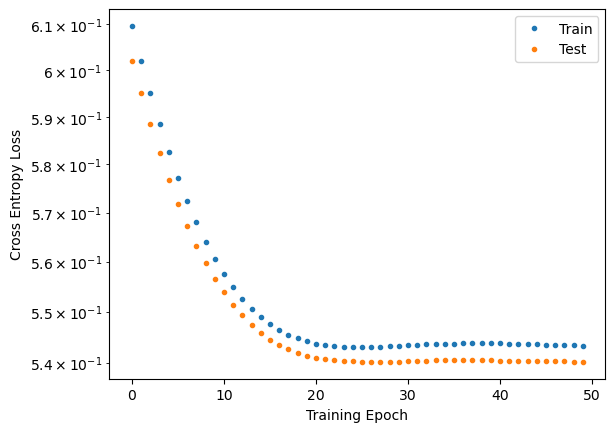

In [10]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In [11]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.sigmoid(net(x_test_tensor)).detach().cpu()
y_pred_train= torch.sigmoid(net(x_train_tensor)).detach().cpu()

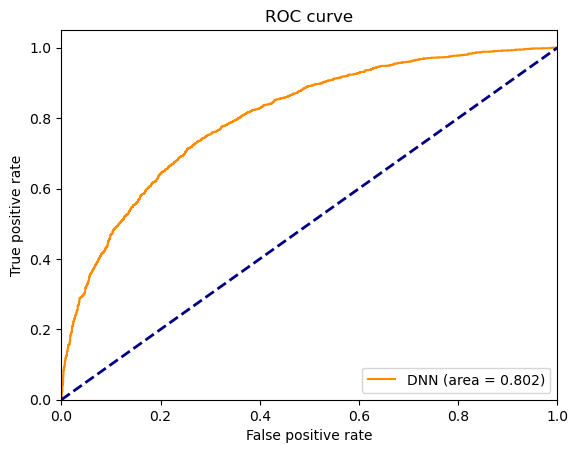

In [12]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
def ListToGraph(l,bins,color,low=0,high=1,weight=0):
    counts,bin_edges = np.histogram(l,bins,range=(low,high))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    err = np.sqrt(counts)
    if weight==0:
        weight=1./(sum(counts)*(bin_edges[1]-bin_edges[0]))
    counts = weight*counts
    err = weight*err
    return plt.errorbar(bin_centres, counts, yerr=err, fmt='o',color=color)

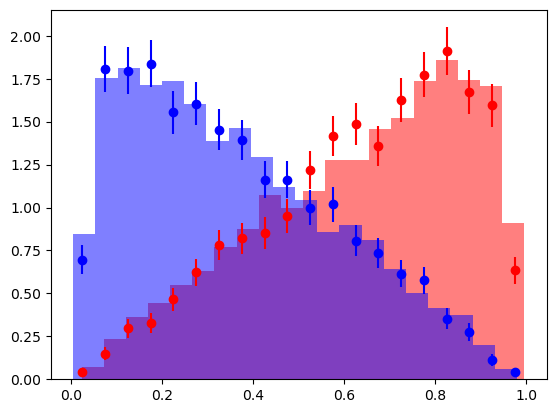

In [14]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
#plt.yscale("log")
plt.show()

In [15]:
bias=net[0].bias.detach()[0]
weight=net[0].weight.detach()[0][0]
print(bias)
print(weight)
sc.inverse_transform([[-1.*bias/weight]])

tensor(-0.0018)
tensor(-1.4441)


array([[0.0968043]])

The calculation above yields the optimal cut value in the un-transformed feature space.

It looks, though, like we can only either fix or not-fix the entire weight matrix, so it won't be easy to use Linear layers to train selection against multiple features.  We'll have to implement as a series of 1D transforms, and then check BCE (or equivalent) on the sum.

# Now in more dimensions

In [25]:
N=20000 # number of points
m=10 # dimensions

In [26]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)
means_widths=np.random.randn(m,2,2)
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

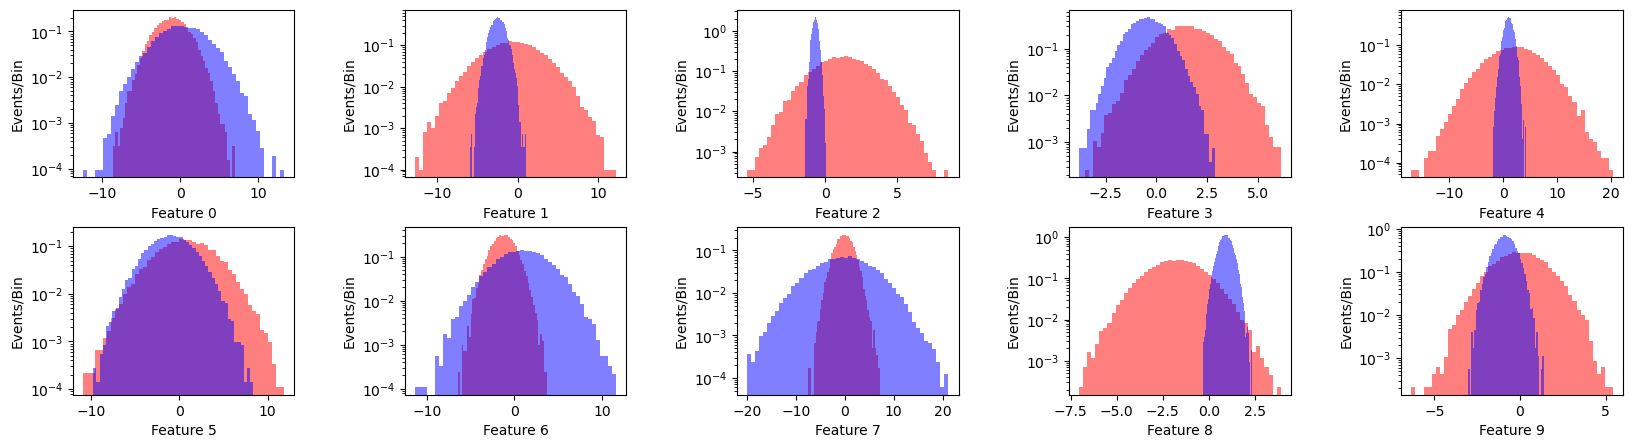

In [27]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [29]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

For this kind of network, need the 
* inputs to be our matrix of N rows (events) and m columns (features)
* weights and biases, with some shape that enables the output to be:
* outputs that give the distance of each feature from the correct classification

Ideally will have expressions like (this is not real matrix algebra, unfortunately, but if only we could cheat):

$$
\begin{bmatrix}
x_{1}\\
...\\
x_{m}
\end{bmatrix}
\begin{bmatrix}
w_{1} & ... & w_{m}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
y_{1} & ... &y_{m}
\end{bmatrix}
$$

For a large group of events:

$$
\begin{bmatrix}
w_{1}\\
...\\
w_{m}
\end{bmatrix}
\begin{bmatrix}
x_{11} & ... & x_{1m}\\
... & ... & ...\\
x_{N1} & ... & x_{Nm}
\end{bmatrix}
+
\begin{bmatrix}
b_{1} & ... &b_{m}
\end{bmatrix}
= 
\begin{bmatrix}
(w_{1}x_{11}+b_{1}) & ... &(w_{m}x_{1m}+b_{m})\\
... & ... & ...\\
(w_{1}x_{N1}+b_{1}) & ... &(w_{m}x_{Nm}+b_{m})
\end{bmatrix}
=
\begin{bmatrix}
y_{11} & ... &y_{1m}\\
... & ... & ...\\
y_{N1} & ... &y_{Nm}
\end{bmatrix}
$$

Then we need a way to calculate a single "score" based on the $y$ values for a given event.  Could be some distance in the $m$-dimensional feature space (1-norm or 2-norm), or just whether it failed a single cut or not, etc.

In [30]:
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F

class OneToOneLinear(torch.nn.Module):

    __constants__ = ['features']
    features: int
    weight: Tensor

    def __init__(self, features: int, 
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.features = features
        self.weight = Parameter(torch.empty(features, **factory_kwargs))
        self.bias = Parameter(torch.empty(features, **factory_kwargs))
        self.reset_parameters()

    def reset_parameters(self) -> None:
        bound=1./math.sqrt(self.features)
        torch.nn.init.uniform_(self.weight, -bound, bound)
        torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input: Tensor) -> Tensor:

        # need to turn the "weights" vector into a matrix with the vector 
        # elements on the diagonal, and zeroes everywhere else.
        targets = torch.matmul(input,torch.diag(self.weight))+self.bias
        return targets

    def extra_repr(self) -> str:
        return f'in_features={self.features}, bias={self.bias}'


class OneToOneLinearActivation(torch.nn.Module):
    __constants__ = ['inplace']
    inplace: bool
    scalefactor: float

    def __init__(self,
                 scalefactor = 1.0, 
                 inplace: bool = False):
        super().__init__()
        self.inplace = inplace
        self.scalefactor = scalefactor

    def forward(self, input: Tensor) -> Tensor:
        # this is a bit steeper than sigmoid
        return (torch.tanh(self.scalefactor*input)+1.)/2.

        # this also works
        #return torch.sigmoid(input)

    def extra_repr(self) -> str:
        inplace_str = 'inplace=True' if self.inplace else ''
        return inplace_str
    

In [31]:
torch.manual_seed(123)
net = torch.nn.Sequential(
    OneToOneLinear(m),
    OneToOneLinearActivation()
)

torch.save(net.state_dict(), 'net.pth')

# net_outputs in this case is a list of output scores for each event, one score per input features.
# need to try to push these towards 1 for signal, and 0 for background.
def outputs_to_labels(net_outputs, features):
    # an infinity norm.  this gives good efficiency, but basically gives up on a number
    # of cuts for reasons that are unclear to me, setting cut values way below or above
    # both signal and background distributions.  Can use either min or max, give very
    # similar results.
    #
    # targets = torch.min(torch.abs(net_outputs),1,keepdim=True).values.squeeze(1)

    # do the silly thing and sum over all the outputs.  each output weighted the same,
    # misclassification contributes to a larger loss value.
    # This gives an excellent summary score that has near perfect discrimination,
    # but does a terrible job of creating a set of cuts that has good efficiency, at
    # least when combined with a BCE loss function.  Each individual cut is snug up
    # against where signal and background distributions cross, almost perfectly.  it
    # looks pretty, but not useful combined with BCE.
    #
    targets = torch.sum(net_outputs,1)/features
    
    # there's no variation on this that seems to work well. 
    # loss function is capped within a range less than [0,1], or get errors.
    #
    # targets = torch.sqrt(torch.sum(torch.square(net_outputs,1))/features

    # this doesn't seem to work at all.  not sure why.
    #print(net_outputs[0])
    #print(torch.gt(net_outputs[0],0.5))
    #print(torch.all(torch.gt(net_outputs[0],0.5)))
    # targets = torch.autograd.Variable(torch.all(torch.gt(net_outputs,0.5),dim=1).float(), requires_grad=True)
    
    #print(targets)
    return targets

bce_loss_fn = torch.nn.BCELoss()
def loss_fn (y_pred, y_true, features):
    return bce_loss_fn(outputs_to_labels(y_pred,features),y_true)

In [32]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
batch_size=int(len(y_train)/1) # one batch
epochs=50

In [33]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch, m)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss=loss_fn(y_pred, y_test_tensor, m)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print("Completed epoch %2d in %4.1fs, Train loss=%4.1e, Test loss=%4.1e" % (epoch, elapsed_time, loss.data, test_loss.data))

Completed epoch  0 in  0.8s, Train loss=6.6e-01, Test loss=5.5e-01
Completed epoch  1 in  0.5s, Train loss=5.5e-01, Test loss=4.5e-01
Completed epoch  2 in  0.8s, Train loss=4.5e-01, Test loss=4.0e-01
Completed epoch  3 in  0.8s, Train loss=4.0e-01, Test loss=3.7e-01
Completed epoch  4 in  0.5s, Train loss=3.7e-01, Test loss=3.6e-01
Completed epoch  5 in  0.8s, Train loss=3.6e-01, Test loss=3.5e-01
Completed epoch  6 in  0.6s, Train loss=3.5e-01, Test loss=3.4e-01
Completed epoch  7 in  0.8s, Train loss=3.4e-01, Test loss=3.4e-01
Completed epoch  8 in  0.8s, Train loss=3.4e-01, Test loss=3.3e-01
Completed epoch  9 in  0.6s, Train loss=3.3e-01, Test loss=3.3e-01
Completed epoch 10 in  0.8s, Train loss=3.3e-01, Test loss=3.3e-01
Completed epoch 11 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 12 in  0.5s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 13 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch 14 in  0.8s, Train loss=3.2e-01, Test loss=3.2

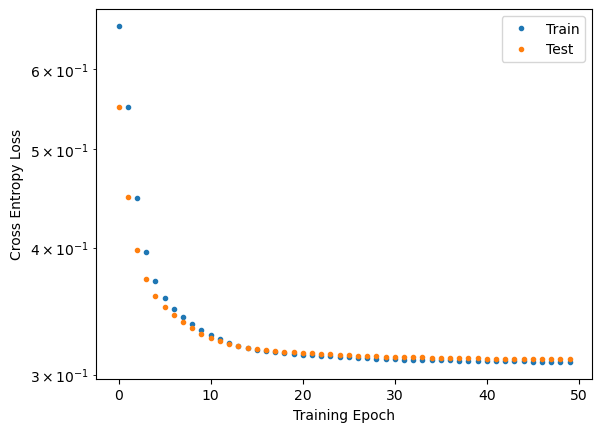

In [34]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

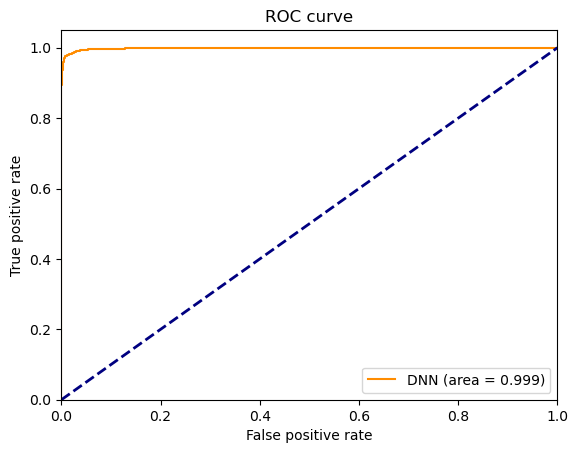

In [35]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = outputs_to_labels(net(x_test_tensor),m).detach().cpu()
y_pred_train= outputs_to_labels(net(x_train_tensor),m).detach().cpu()

fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

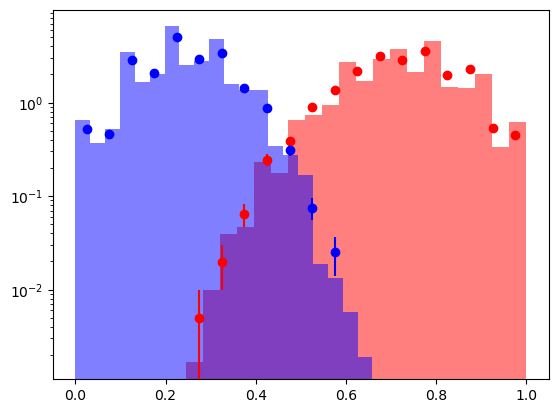

In [36]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
plt.yscale("log")
plt.show()

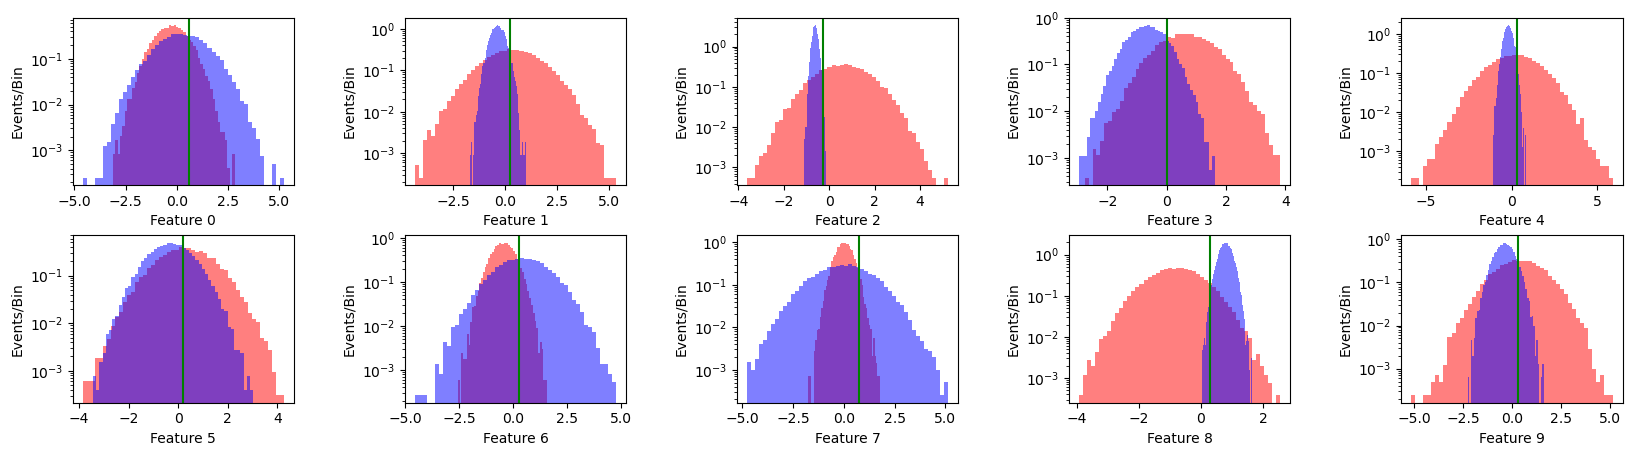

In [37]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net[0].bias.detach().numpy()
weights=net[0].weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = scaled_cuts[b], color='g')

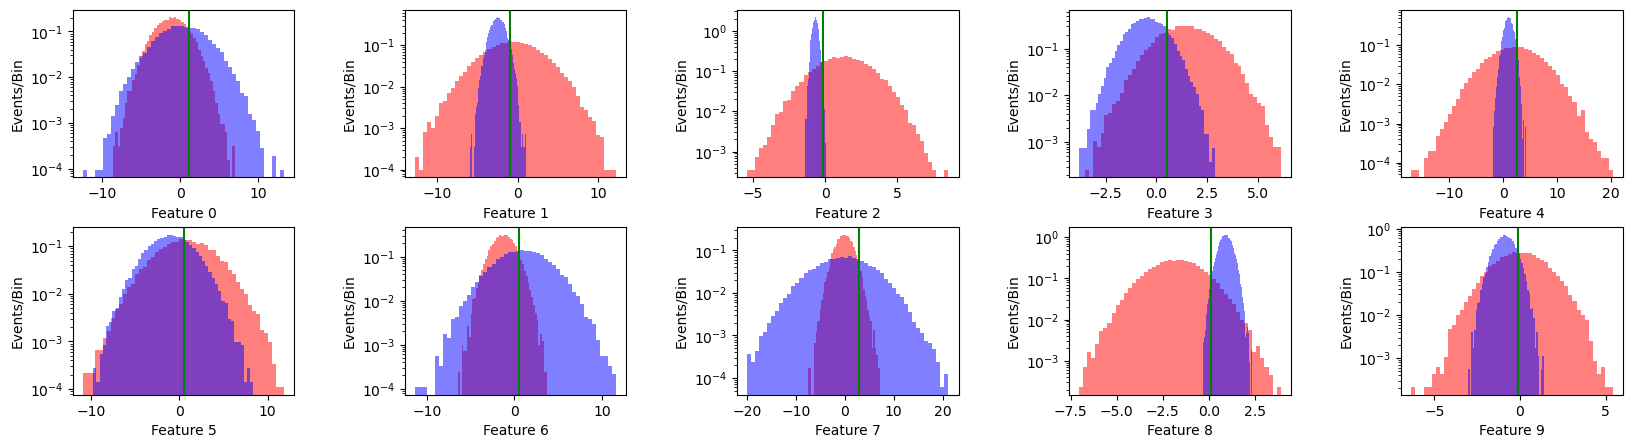

In [38]:
# Distributions before scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

cuts=sc.inverse_transform([scaled_cuts])[0]

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    ax.axvline(x = cuts[b], color='g')

Now, what is this finding?  It's encoding the cut values in the weights and biases, but we need to evaluate the
efficiency of those cuts, not just the overall performance.

One tricky thing is whether these are "less than" cuts or "greater than" cuts.  The output of the network, prior to activation, should push background-like events to negative values, and signal-like events to positive values, such that the activation function maps them properly onto a zero-to-one range.  I think it's then enough to pass the event through the network and test if the values are less than or greater than zero.

Try a max(outputs) function, basically inf-norm.


In [39]:
total_test=len(y_test)

num_pass_test=0
test_outputs = net(x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
falses=torch.tensor(m*[False])
for i in range(len(test_outputs)):
    #for j in range(m):
    #    if scaled_cuts[j]<0:
    #        if x_test_tensor[i][j]
    tt=0.5+torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)
    if i==1:
        print(x_test[i])
        print(y_test[i])
        print(x_test_tensor[i])
        print(test_outputs[i])
        print(t)
    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    #elif torch.equal(t,falses) and y_test[i]==0.:
    #    num_pass_test+=1

effic_test = num_pass_test / total_test
print(effic_test)

[-2.54454249 -4.65963979  1.58261081  1.06084618  6.51575633  0.16097758
 -0.47642914 -1.62256609 -2.45512417  0.07704385]
1.0
tensor([-0.8169, -1.2308,  0.8251,  0.3656,  1.5537,  0.0960, -0.1293, -0.3438,
        -1.2086,  0.4481])
tensor([1.0000, 0.0000, 1.0000, 0.9865, 1.0000, 0.2251, 0.9946, 1.0000, 1.0000,
        0.8975])
tensor([ True, False,  True,  True,  True, False,  True,  True,  True,  True])
0.0135


This clearly isn't working very well.  I think the problem is that the BCE loss is not useful here, since it
relies on computing a single summary score for each event.  

# Modifying the Loss Function

This works now, with m=1 and m=2.

In [40]:
N=20000 # number of points
m=10 # dimensions

In [41]:
# array of means and widths for gaussians,
# indices are:
# - number of dimensions
# - signal (0) vs background (1)
# - mean (0) vs width (1)
np.random.seed(123)

# if we want more control over the function, for example
means_widths=[[[4,0.4],
               [-2,.10]],
              [[3,1.0],
               [-1,0.5]]]

means_widths=np.random.randn(m,2,2)               
width_scale_factor=2.
mean_scale_factor=2.

# now construct the training data.  after taking transpose, should be N rows by m columns.  
x_signal=np.array([means_widths[i][0][0]+width_scale_factor*np.fabs(means_widths[i][0][1])*np.random.randn(N) for i in range(m)]).T
y_signal=np.ones(N)
x_backgr=np.array([means_widths[i][1][0]+width_scale_factor*np.fabs(means_widths[i][1][1])*np.random.randn(N) for i in range(m)]).T
y_backgr=np.zeros(N)
x=np.concatenate((x_signal,x_backgr))
y=np.concatenate((y_signal,y_backgr))

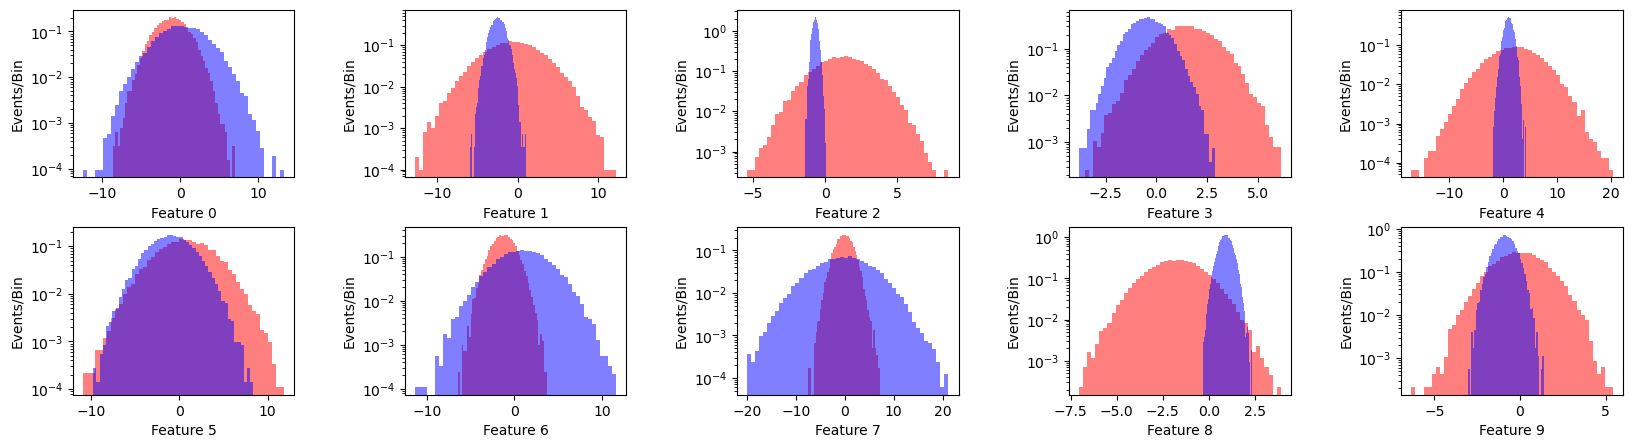

In [42]:
fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

sc = StandardScaler()
x_train_scaled = sc.fit_transform(x_train)
x_test_scaled  = sc.transform(x_test)

In [44]:
x_train_tensor=torch.tensor(x_train_scaled,dtype=torch.float)
y_train_tensor=torch.tensor(y_train,dtype=torch.float)

x_test_tensor=torch.tensor(x_test_scaled,dtype=torch.float)
y_test_tensor=torch.tensor(y_test,dtype=torch.float)

In [45]:
def loss_fn (y_pred, y_true, features, net, 
             target_signal_efficiency=0.8,
             alpha=1., beta=1., gamma=0.001):
    
    # this is differentiable, unlike using torch.all(torch.gt()) or something else that yields booleans.
    # will converge to 1 for things that pass all cuts, and to zero for things that fail any single cut.
    all_results=torch.prod(y_pred,dim=1)

    # signal efficiency: (selected events that are true signal) / (number of true signal)
    signal_results = all_results * y_true
    signal_efficiency = torch.sum(signal_results)/torch.sum(y_true)

    # background efficiency: (selected events that are true background) / (number of true background)
    background_results = all_results * (1.-y_true)
    background_efficiency = torch.sum(background_results)/(torch.sum(1.-y_true))

    cuts=-net.bias/net.weight
    
    # * force signal efficiency to converge to a target value
    # * force background efficiency to small values at target efficiency value.
    # * also prefer to have the cuts be close to zero, so they're not off at some crazy 
    #   value even if we prefer for the cut to not have much impact on the efficiency 
    #   or rejection.
    #
    # should modify the efficiency target requirement here, to make this more 
    # like consistency with e.g. a gaussian distribution rather than just a penalty 
    # calculated from r^2 distance.
    #
    # for both we should prefer to do something like "sum(square())" or something.
    loss = alpha*torch.square(target_signal_efficiency-signal_efficiency) + beta*background_efficiency + gamma*torch.sum(torch.square(cuts))/features
    
    # sanity check in case we ever need it, should work
    #loss=bce_loss_fn(outputs_to_labels(y_pred,features),y_true)
    
    return loss, signal_efficiency, background_efficiency

In [46]:
torch.manual_seed(123)
activation_input_scale_factor=2.

In [47]:
net = torch.nn.Sequential(
    OneToOneLinear(m),
    OneToOneLinearActivation(activation_input_scale_factor)
)
torch.save(net.state_dict(), 'net.pth')

In [48]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
batch_size=int(len(y_train)/1) # one batch
epochs=100
alpha=0.5   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3 # scaling factor for how aggressively to push the cuts to zero
target_efficiency = 0.8

In [49]:
losses = []
losses_test = []

net.load_state_dict(torch.load('net.pth',weights_only=True))

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss, s_eff, b_eff = loss_fn(y_pred, y_batch, m, net[0], target_efficiency, alpha, beta, gamma)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss, s_eff, b_eff =loss_fn(y_pred, y_test_tensor, m, net[0], target_efficiency, alpha, beta, gamma)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    bias=net[0].bias[0]
    weight=net[0].weight[0]
    #weight={weight:4.1e}, bias={bias:4.1e}, 
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}, cut={-bias/weight:4.1e}, sig_eff={100*s_eff:4.1f}%, bkg_eff={100*b_eff:6.3f}%")

Completed epoch  0 in  0.9s, Train loss=3.3e-01, Test loss=3.2e-01, cut=-7.4e-02, sig_eff= 0.0%, bkg_eff= 0.002%
Completed epoch  1 in  0.6s, Train loss=3.2e-01, Test loss=3.2e-01, cut=2.6e-01, sig_eff= 0.1%, bkg_eff= 0.002%
Completed epoch  2 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01, cut=4.8e-01, sig_eff= 0.1%, bkg_eff= 0.002%
Completed epoch  3 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01, cut=6.3e-01, sig_eff= 0.3%, bkg_eff= 0.002%
Completed epoch  4 in  0.6s, Train loss=3.2e-01, Test loss=3.2e-01, cut=7.3e-01, sig_eff= 0.6%, bkg_eff= 0.003%
Completed epoch  5 in  0.9s, Train loss=3.2e-01, Test loss=3.1e-01, cut=8.3e-01, sig_eff= 1.2%, bkg_eff= 0.005%
Completed epoch  6 in  0.9s, Train loss=3.1e-01, Test loss=3.0e-01, cut=9.4e-01, sig_eff= 2.2%, bkg_eff= 0.009%
Completed epoch  7 in  0.5s, Train loss=3.0e-01, Test loss=2.9e-01, cut=1.1e+00, sig_eff= 3.8%, bkg_eff= 0.015%
Completed epoch  8 in  0.9s, Train loss=2.9e-01, Test loss=2.8e-01, cut=1.4e+00, sig_eff= 6.2%, bkg_eff

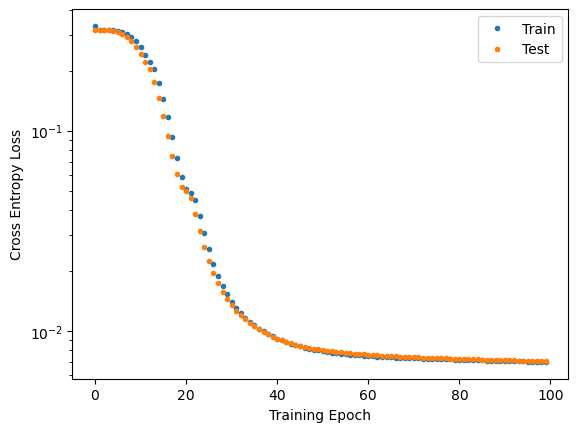

In [50]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

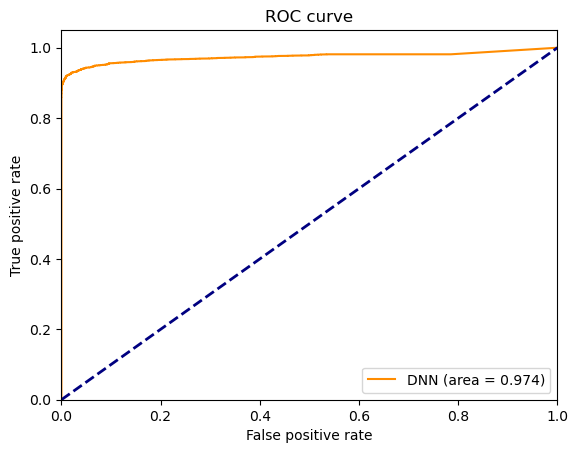

In [51]:
net.eval() # configure the model for evaluation (testing)
y_pred_test = torch.prod(net(x_test_tensor),dim=1).detach().cpu()
y_pred_train= torch.prod(net(x_train_tensor),dim=1).detach().cpu()

fpr, tpr, _ = roc_curve(y_test, y_pred_test.numpy())
roc_auc = roc_auc_score(y_test, y_pred_test.numpy())

plt.figure(1)
lw = 2
plt.plot(fpr, tpr, color="darkorange", label="DNN (area = {:.3f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

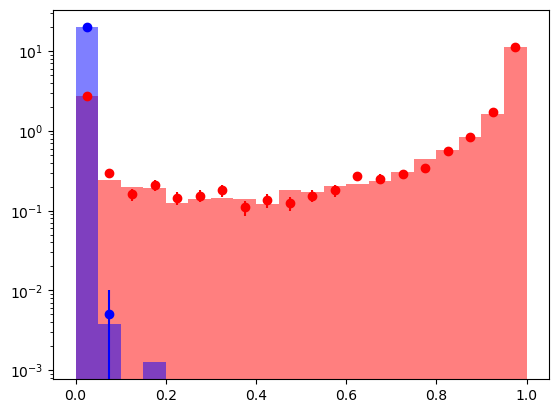

In [52]:
signal_train=[]
signal_test =[]
backgr_train=[]
backgr_test =[]
for y,y_p in zip(y_train,y_pred_train):
    if y==1: signal_train.append(float(y_p))
    else:    backgr_train.append(float(y_p))
for y,y_p in zip(y_test,y_pred_test):
    if y==1: signal_test.append(float(y_p))
    else:    backgr_test.append(float(y_p))

nbins=20
signal_train_hist=plt.hist(signal_train,nbins,density=True,histtype='stepfilled',alpha=0.5,range=(0,1),color='red')
backgr_train_hist=plt.hist(backgr_train,nbins,density=True,histtype='stepfilled',alpha=0.5,range=(0,1),color='blue')
signal_test=ListToGraph(signal_test,nbins,"red")
backgr_test=ListToGraph(backgr_test,nbins,"blue")
plt.yscale("log")
plt.show()

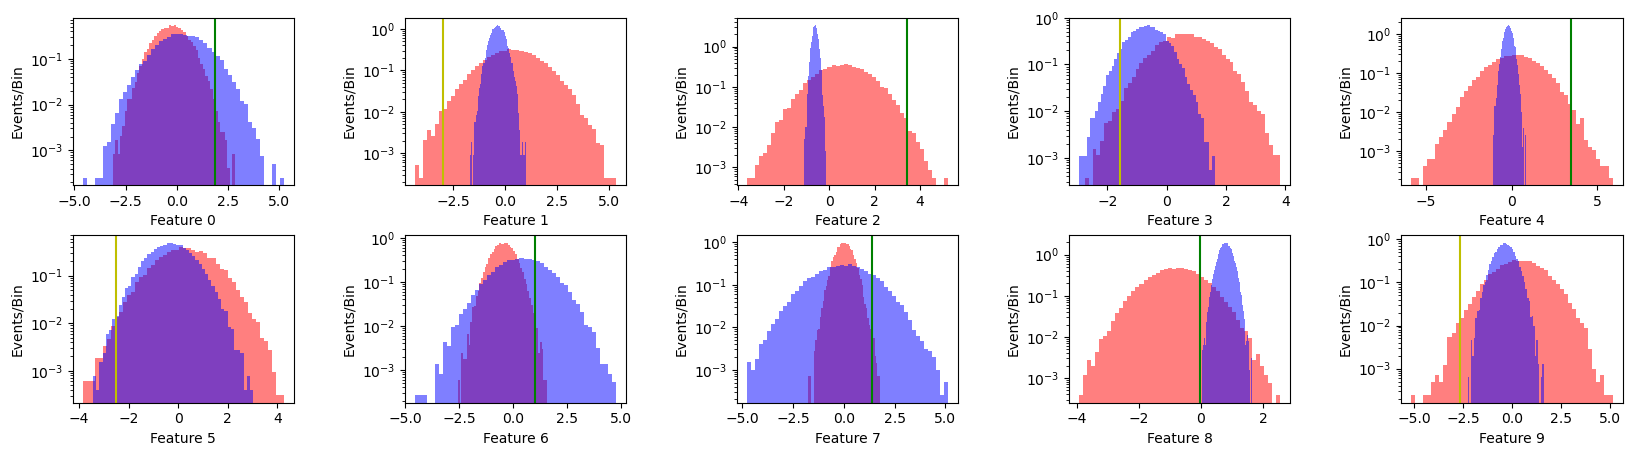

In [53]:
# Distributions after scaling

fig = plt.figure(figsize=(20,5))
fig.tight_layout()
nbins=50

biases=net[0].bias.detach().numpy()
weights=net[0].weight.detach().numpy()
scaled_cuts=-biases/weights

x_signal_scaled=sc.transform(x_signal)
x_backgr_scaled=sc.transform(x_backgr)

for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.3,wspace=0.5)
    plt.yscale('log')
    ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
    ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
    ax.set_xlabel(f"Feature {b}")
    ax.set_ylabel("Events/Bin")
    if weights[b] < 0:
        ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
    else:
        ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"

Apply the cuts on the network inputs.  This corresponds to requiring 

$$ y_i = w_ix_i + b_i > 0 $$

which implies:

$$ x_i > -\frac{b_i}{w_i} $$

We could apply the second criterion, but the first layer of the network already gives us the events that satisfy this condition!  We just need to pass the $x$ inputs through the first layer of the network.  If we pass into the first layer (without the activation function) then the test is $y>0$, if we pass through the full network (including the activation function) then the test is $y'>0.5$.  We'll save a few CPU cycles and just do the first layer of the network.

In [54]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Signal Efficiency with net outputs: 79.3%
Background Efficiency with net outputs: 0.00000%


Note that these efficiencies may be slightly different from what we see in the loss function, which 
computes a floating point number for each event, rather than incrementing an integer.  So a background event that only barely fails the cuts will contribute a little bit towards a non-zero background efficiency in the loss, while in this test it will contribute just as much as an event that fails all cuts badly (i.e. it will contribute nothing to the background efficiency).

# Efficiency scan

The next thing we can think about implementing is setting up an efficiency scan.  Vary the target efficiency and force
the cuts to vary gracefully.  We probably want to implement this as yet another loss function, and add the two losses together in an outer loop.  This means setting up separate networks for each target efficiency, passing the data into all of them to retrieve the losses, and then computing the total loss as the sum of the losses plus the penalty for having cuts that don't behave smoothly

First let's set up some infrastructure to handle multiple efficiency targets, but try to reproduce the results from before.

In [55]:
class EfficiencyScanNetwork(torch.nn.Module):
    def __init__(self,features,effics,activationscale=2.):
        super().__init__()
        self.features = features
        self.effics = effics
        self.activation_input_scale_factor=activationscale
        self.nets = torch.nn.ModuleList([OneToOneLinear(features) for i in range(len(self.effics))])
        self.activation = OneToOneLinearActivation()

    def forward(self, x):
        outputs=torch.stack(tuple(self.activation(self.activation_input_scale_factor*self.nets[i](x)) for i in range(len(self.effics))))
        return outputs

In [56]:
def effic_loss_fn(y_pred, y_true, features, net,
                  alpha=1., beta=1., gamma=0.001, epsilon=0.001,
                  debug=False):

    # probably a better way to do this, but works for now
    sumefficlosses=None    
    for i in range(len(net.effics)):
        effic=net.effics[i]
        efficnet = net.nets[i]
        l=loss_fn(y_pred[i], y_true, features, 
                  efficnet, effic,
                  alpha, beta, gamma)[0]
        if sumefficlosses==None:
            sumefficlosses=l
        else:
            sumefficlosses=torch.add(sumefficlosses,l)
        
    # now set up global penalty for cuts that vary net by net.
    # some options:
    # a. penalize a large range of cut values
    # b. penalize large changes between nearest neighbors
    # c. test for non-monotonicity?
    #
    # go for b for now.
    #

    #
    # The below implementation isn't quite right, and probably isn't differentiable.
    # Need to find some way to constrain the variation between adjacent cuts in
    # a differentiable way, similar to how the torch.all(torch.gt()) thing was 
    # approximated by torch.prod().
    #
    # Could do something like taking the mean of the cut values, subtracting that off,
    # and...  checking something?
    #
    # see e.g. https://pypi.org/project/monotonicnetworks/ for a more complicated treatment
    #
    sortedeffics=sorted(net.effics)

    if len(sortedeffics)>=3:
        def getcuts(subnet):
            return -subnet.bias/subnet.weight
        def getweights(subnet):
            return subnet.weight
        featureloss = None
        for i in range(1,len(sortedeffics)-1):
            cuts_i   = getcuts(net.nets[i  ])
            cuts_im1 = getcuts(net.nets[i-1])
            cuts_ip1 = getcuts(net.nets[i+1])

            # calculate distance between cuts.  
            fl = torch.pow(cuts_i-cuts_im1,2) + torch.pow(cuts_i-cuts_ip1,2) + torch.pow(cuts_im1-cuts_ip1,2)

            # also need some term that penalizes weights that change sign.  going from positive to negative
            # weights will change the interpretation from "less than" to "greater than" or vice versa.
            fl = fl + \
            (features - torch.sum(torch.tanh(2*net.nets[i].weight)*torch.tanh(net.nets[i-1].weight))) + \
            (features - torch.sum(torch.tanh(2*net.nets[i].weight)*torch.tanh(net.nets[i+1].weight)))
            
            if featureloss == None:
                featureloss = fl
            else:
                featureloss = featureloss + fl
        sumfeaturelosses = torch.sum(featureloss)/(3.*(len(sortedeffics)-2))/features
        loss = sumefficlosses + epsilon*sumfeaturelosses    
    else:
        loss = sumefficlosses

    return loss

In [57]:
targeteffics=[0.8]

In [58]:
torch.manual_seed(123)
net = EfficiencyScanNetwork(m,targeteffics) # will take m inputs, return m*n_eff outputs

{n: theta.shape for n, theta in net.named_parameters()}

{'nets.0.weight': torch.Size([10]), 'nets.0.bias': torch.Size([10])}

In [59]:
# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
print(net.parameters())
batch_size=int(len(y_train)/1.) # one batch
epochs=100
alpha=0.5   # scaling factor to tune how important hitting the target signal efficiency is
beta=10.    # scaling factor to tune how important background rejection is
gamma=1e-3  # scaling factor for how aggressively to push the cuts to zero
epsilon=0   # how much to penalize deviations

<generator object Module.parameters at 0x7f09f3596ea0>


In [60]:
losses = []
losses_test = []

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        loss.backward()
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

Completed epoch  0 in  0.9s, Train loss=3.3e-01, Test loss=3.2e-01
Completed epoch  1 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  2 in  0.6s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  3 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  4 in  0.8s, Train loss=3.2e-01, Test loss=3.2e-01
Completed epoch  5 in  0.5s, Train loss=3.2e-01, Test loss=3.1e-01
Completed epoch  6 in  0.8s, Train loss=3.1e-01, Test loss=3.0e-01
Completed epoch  7 in  0.8s, Train loss=3.0e-01, Test loss=2.9e-01
Completed epoch  8 in  0.6s, Train loss=2.9e-01, Test loss=2.8e-01
Completed epoch  9 in  0.8s, Train loss=2.8e-01, Test loss=2.6e-01
Completed epoch 10 in  0.8s, Train loss=2.6e-01, Test loss=2.4e-01
Completed epoch 11 in  0.5s, Train loss=2.4e-01, Test loss=2.2e-01
Completed epoch 12 in  0.8s, Train loss=2.2e-01, Test loss=2.0e-01
Completed epoch 13 in  0.8s, Train loss=2.0e-01, Test loss=1.7e-01
Completed epoch 14 in  0.5s, Train loss=1.7e-01, Test loss=1.5

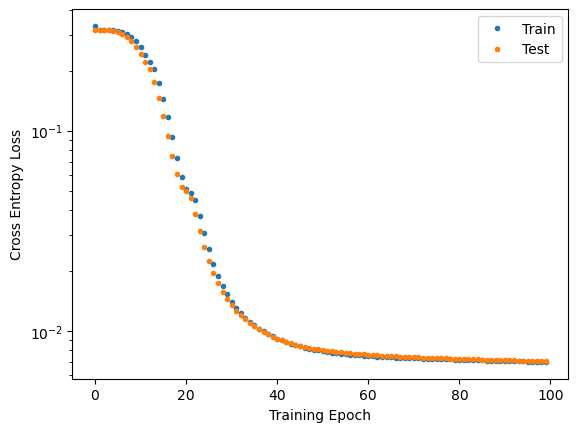

In [61]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

Target efficiency: 80.0%
[ 1.8662235  -3.0002766   3.4398236  -1.594471    3.4531348  -2.5126302
  1.014105    1.4078438  -0.03443984 -2.6835556 ]


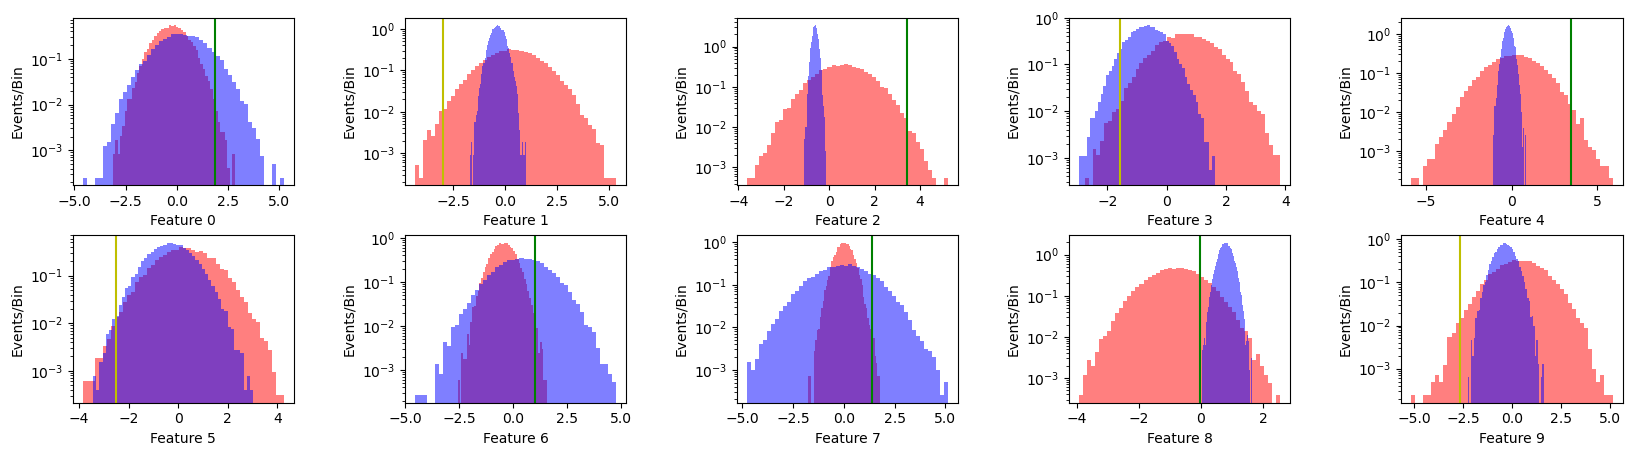

In [62]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(scaled_cuts)
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

In [63]:
num_pass_test=0.
num_bg_pass_test=0.
test_outputs = net.nets[0](x_test_tensor).detach().cpu()
trues=torch.tensor(m*[True])
for i in range(len(test_outputs)):

    tt=torch.zeros(m)
    t=torch.gt(test_outputs[i],tt)

    if torch.equal(t,trues) and y_test[i]==1.:
        num_pass_test+=1
    elif torch.equal(t,trues) and y_test[i]!=1.:
        num_bg_pass_test+=1.
    

effic_test = num_pass_test / np.sum(y_test)
print(f"Signal Efficiency with net outputs: {100*effic_test}%")

bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
print(f"Background Efficiency with net outputs: {100*bg_effic_test}%")

Signal Efficiency with net outputs: 79.32237169905332%
Background Efficiency with net outputs: 0.0%


## Multiple efficiency targets

Now let's test a few different efficiency targets and see how it learns.

This technique is sensitive to getting stuck in local minima, benefits from minibatch training to not get trapped.

In [64]:
targeteffics=[0.6,0.7,0.8,0.9]
torch.manual_seed(123)
net = EfficiencyScanNetwork(m,targeteffics,1.) # will take m inputs, return m*n_eff outputs
print({n: theta.shape for n, theta in net.named_parameters()})

# some hyperparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.5)
print(net.parameters())
nbatches=10
batch_size=int(len(y_train)/nbatches)
epochs=100
alpha=1.     # scaling factor to tune how important hitting the target signal efficiency is
beta=5.      # scaling factor to tune how important background rejection is
gamma=1e-3   # scaling factor for how aggressively to push the cuts to zero
epsilon=1e-2 # how much to penalize deviations of cuts for adjacent target efficiencies

losses = []
losses_test = []

xy_train = torch.utils.data.TensorDataset(x_train_tensor.float(),y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=batch_size, shuffle=True)

debug=False
if debug:
    epochs=20

for epoch in range(epochs):
    net.train()
    start_time = time.time()
    for x_batch, y_batch in loader:
        y_pred = net(x_batch)
        optimizer.zero_grad()
        loss = effic_loss_fn(y_pred, y_batch, m, net, alpha, beta, gamma, epsilon,debug=debug)
        if debug:
            print(-net.nets[0].bias/net.nets[0].weight)
            print(-net.nets[1].bias/net.nets[1].weight)
        loss.backward()
        if debug:
            print(net.nets[0].bias)
            print(net.nets[1].bias)
            print(net.nets[0].weight)
            print(net.nets[1].weight)
            getBack(loss.grad_fn)
            #print(-net.nets[0].bias/net.nets[0].weight)
            #print(-net.nets[1].bias/net.nets[1].weight)
        optimizer.step()
    losses.append(loss.data)
    net.eval() # configure the model for evaluation (testing)
    y_pred = net(x_test_tensor)
    test_loss = effic_loss_fn(y_pred, y_test_tensor, m, net, alpha, beta, gamma, epsilon)
    losses_test.append(test_loss.data)
    end_time=time.time()
    elapsed_time = end_time - start_time
    print(f"Completed epoch {epoch:2d} in {elapsed_time:4.1f}s, Train loss={loss.data:4.1e}, Test loss={test_loss.data:4.1e}")

{'nets.0.weight': torch.Size([10]), 'nets.0.bias': torch.Size([10]), 'nets.1.weight': torch.Size([10]), 'nets.1.bias': torch.Size([10]), 'nets.2.weight': torch.Size([10]), 'nets.2.bias': torch.Size([10]), 'nets.3.weight': torch.Size([10]), 'nets.3.bias': torch.Size([10])}
<generator object Module.parameters at 0x7f0a02679540>
Completed epoch  0 in  0.8s, Train loss=2.4e+00, Test loss=2.4e+00
Completed epoch  1 in  1.0s, Train loss=2.3e+00, Test loss=2.3e+00
Completed epoch  2 in  0.8s, Train loss=2.3e+00, Test loss=2.3e+00
Completed epoch  3 in  1.0s, Train loss=2.3e+00, Test loss=2.3e+00
Completed epoch  4 in  0.7s, Train loss=2.0e+00, Test loss=2.0e+00
Completed epoch  5 in  0.9s, Train loss=1.8e+00, Test loss=1.7e+00
Completed epoch  6 in  0.7s, Train loss=1.3e+00, Test loss=1.3e+00
Completed epoch  7 in  1.0s, Train loss=9.3e-01, Test loss=9.0e-01
Completed epoch  8 in  0.8s, Train loss=8.3e-01, Test loss=8.0e-01
Completed epoch  9 in  0.8s, Train loss=6.6e-01, Test loss=6.1e-01
Co

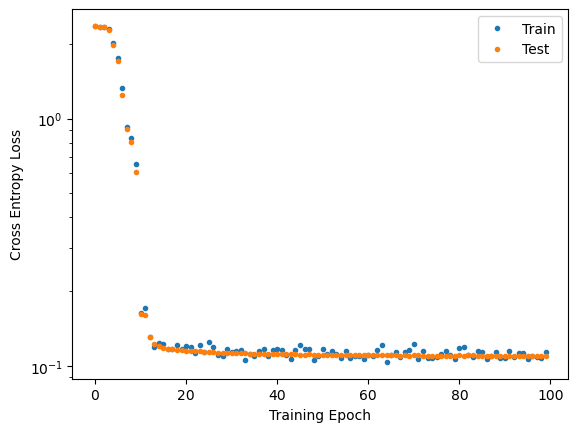

In [65]:
plt.plot(losses, '.', label="Train")
plt.plot(losses_test, '.', label="Test")
plt.legend()
plt.xlabel('Training Epoch')
plt.ylabel('Cross Entropy Loss')
plt.yscale('log');

In [66]:
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    
    num_pass_test=0.
    num_bg_pass_test=0.
    test_outputs = net.nets[n](x_test_tensor).detach().cpu()
    trues=torch.tensor(m*[True])
    for i in range(len(test_outputs)):
    
        tt=torch.zeros(m)
        t=torch.gt(test_outputs[i],tt)
    
        if torch.equal(t,trues) and y_test[i]==1.:
            num_pass_test+=1
        elif torch.equal(t,trues) and y_test[i]!=1.:
            num_bg_pass_test+=1.
        
    
    effic_test = num_pass_test / np.sum(y_test)
    print(f"Signal Efficiency with net outputs: {100*effic_test:4.1f}%")
    
    bg_effic_test = num_bg_pass_test / np.sum(1.-y_test)
    print(f"Background Efficiency with net outputs: {100*bg_effic_test:6.5f}%")

Target efficiency: 60.0%
Signal Efficiency with net outputs: 58.9%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 70.0%
Signal Efficiency with net outputs: 67.6%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 80.0%
Signal Efficiency with net outputs: 76.4%
Background Efficiency with net outputs: 0.00000%
Target efficiency: 90.0%
Signal Efficiency with net outputs: 84.2%
Background Efficiency with net outputs: 0.05018%


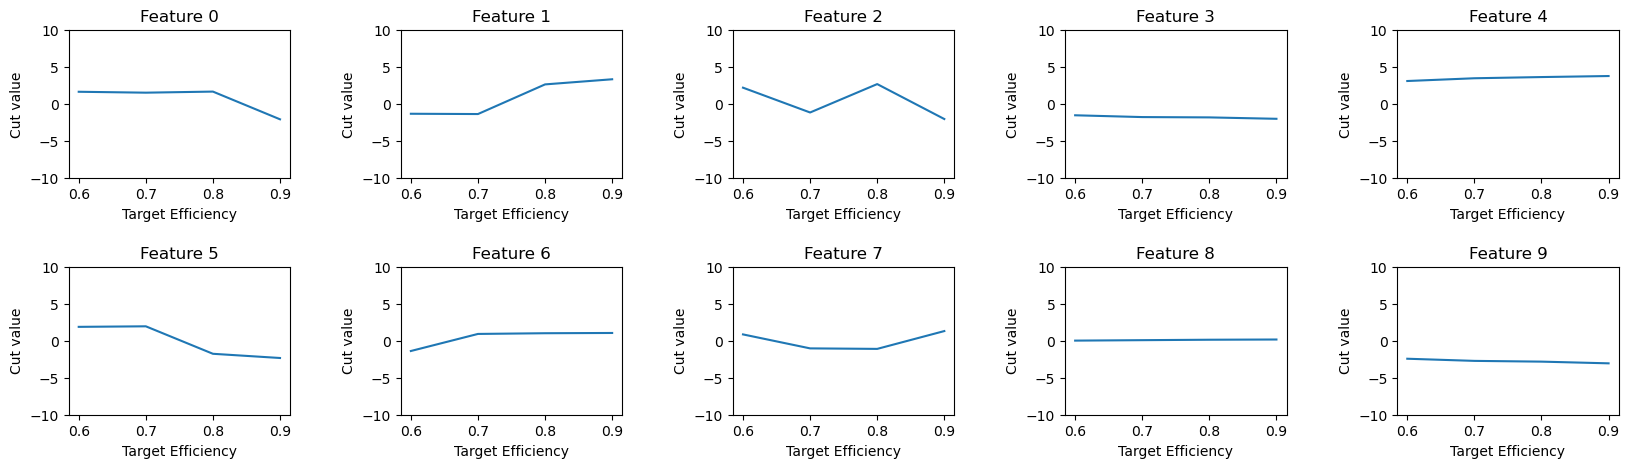

In [67]:
# Distributions of cuts
fig = plt.figure(figsize=(20,5))
fig.tight_layout()

scaled_cuts=[len(targeteffics)*[0] for i in range(m)]
for n in range(len(targeteffics)):
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    cuts=(-biases/weights)
    for f in range(m):
        cutval=cuts[f]
        scaled_cuts[f][n]=cutval
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,scaled_cuts[b])
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel("Cut value")
    ax.set_title(f"Feature {b}")
    ax.set_ylim([-10,10])

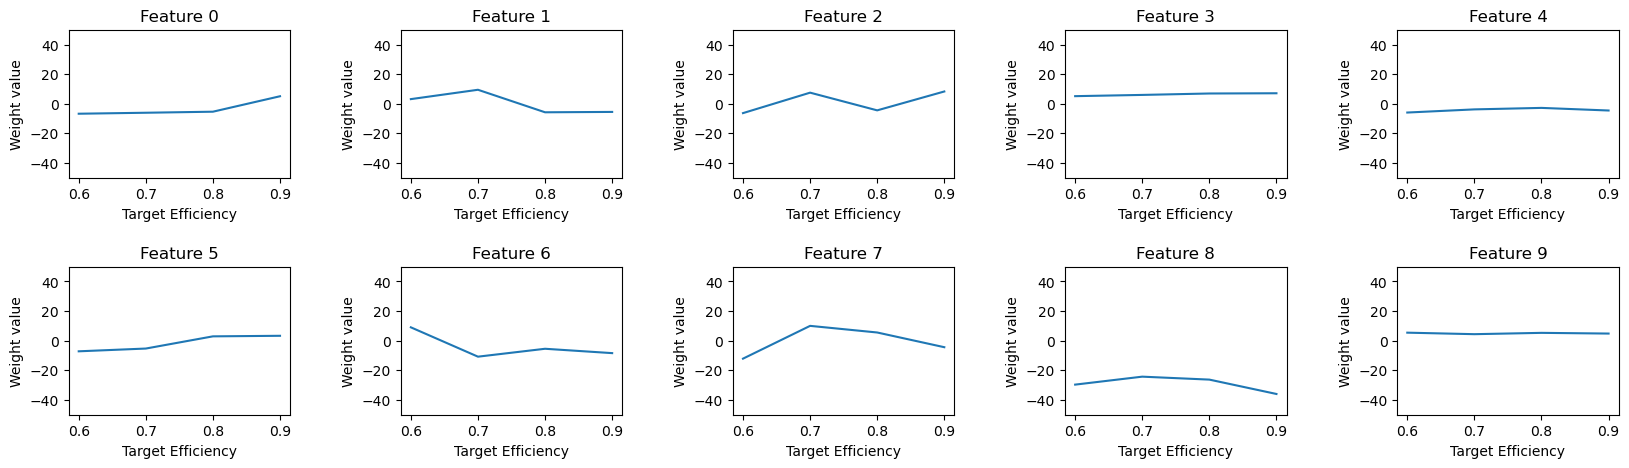

In [71]:
# Distributions of weights
fig = plt.figure(figsize=(20,5))
fig.tight_layout()

weights=[len(targeteffics)*[0] for i in range(m)]
for n in range(len(targeteffics)):
    nweights=net.nets[n].weight.detach().numpy()
    for f in range(m):
        w=nweights[f]
        weights[f][n]=w
for b in range(m):
    ax=fig.add_subplot(2,5,1+b)
    plt.subplots_adjust(hspace=0.6,wspace=0.5)
    ax.plot(targeteffics,weights[b])
    ax.set_xlabel(f"Target Efficiency")
    ax.set_ylabel("Weight value")
    ax.set_title(f"Feature {b}")
    ax.set_ylim([-50,50])

Target efficiency: 60.0%
Cuts are: [ 1.6199558  -1.3500074   2.17278    -1.5557705   3.0722666   1.8685511
 -1.3943847   0.84793717  0.00915937 -2.4380262 ]


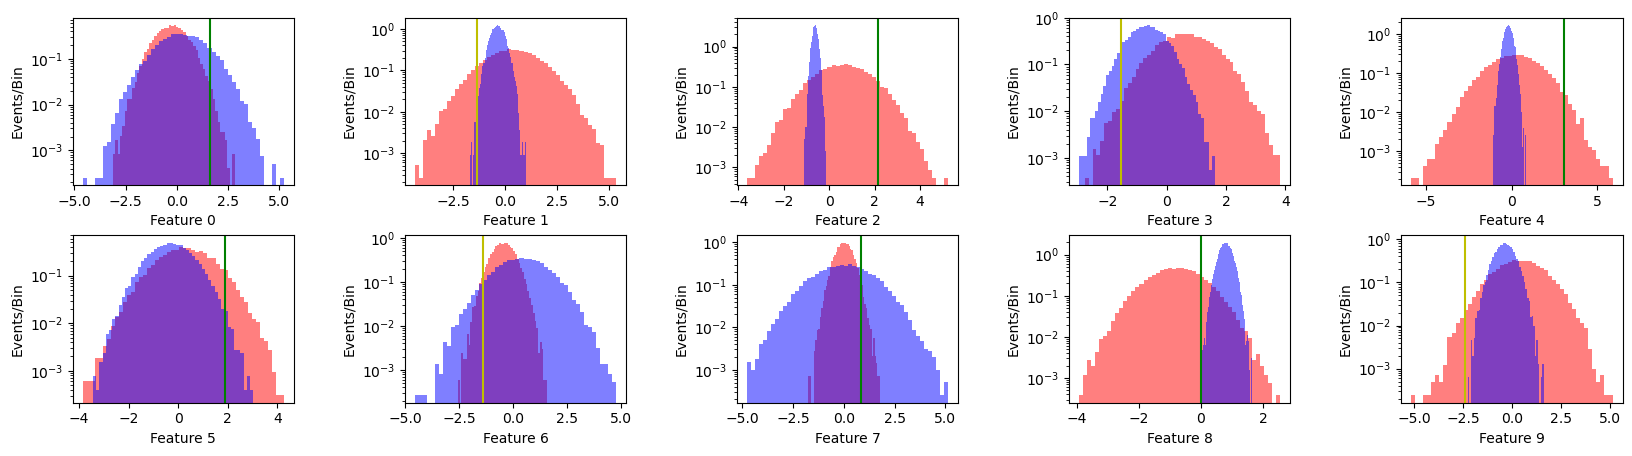

Target efficiency: 70.0%
Cuts are: [ 1.4977077  -1.3890591  -1.1784898  -1.7987341   3.4441967   1.9413583
  0.9120684  -1.0395969   0.06996728 -2.7278256 ]


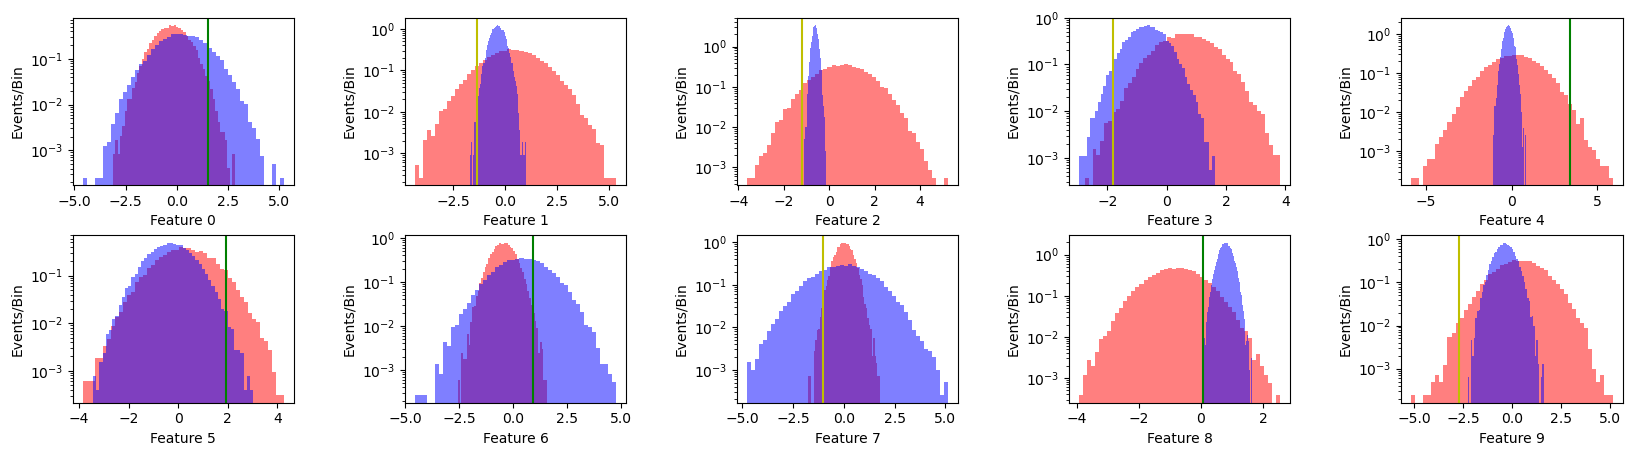

Target efficiency: 80.0%
Cuts are: [ 1.6434577   2.6150043   2.6575222  -1.8416648   3.6063826  -1.7697417
  1.0068653  -1.1080581   0.12822269 -2.829461  ]


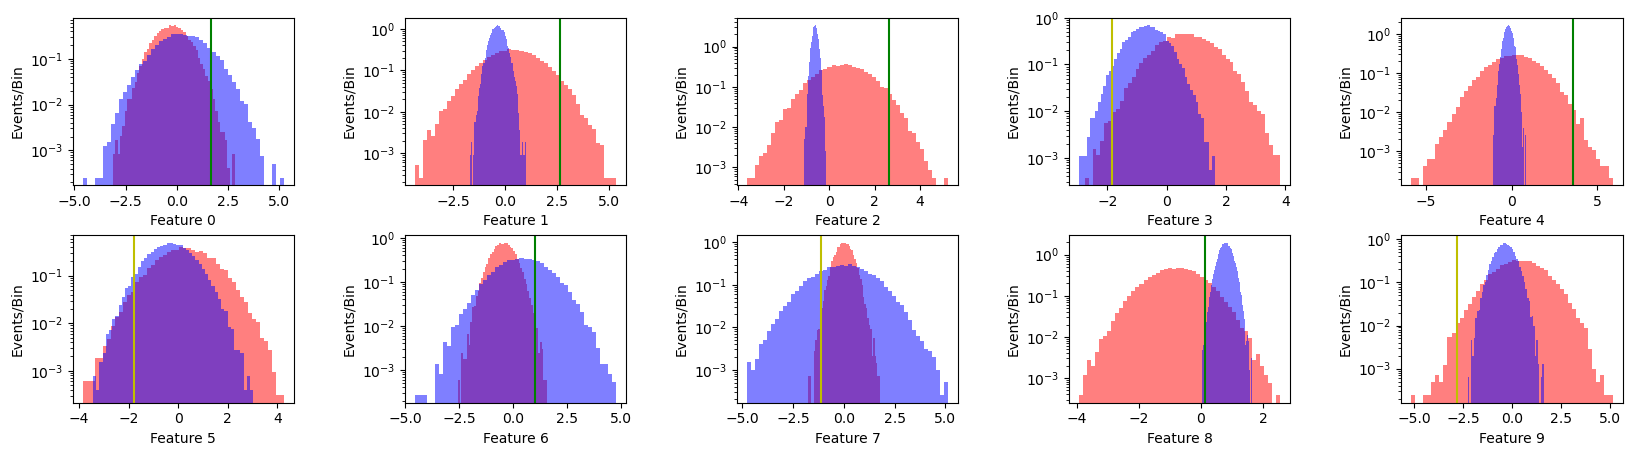

Target efficiency: 90.0%
Cuts are: [-2.101023    3.307834   -2.060642   -2.0311396   3.745198   -2.3384786
  1.0417936   1.2985269   0.15864113 -3.0591638 ]


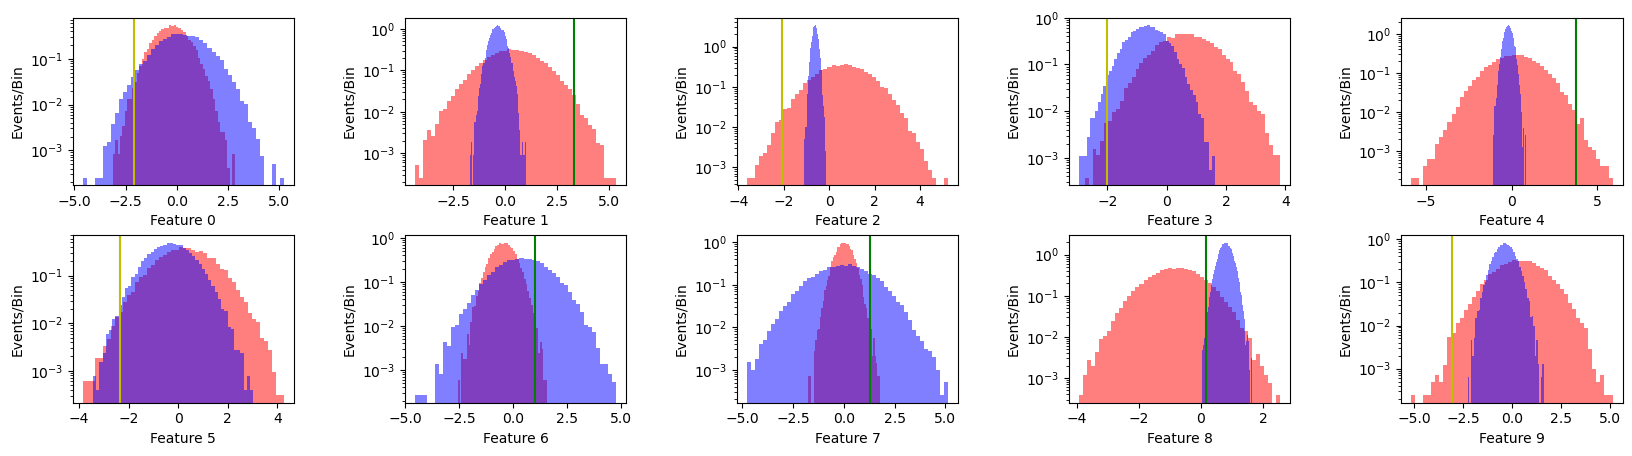

In [68]:
# Distributions after scaling
for n in range(len(targeteffics)):
    print(f"Target efficiency: {targeteffics[n]*100}%")
    fig = plt.figure(figsize=(20,5))
    fig.tight_layout()
    nbins=50
    
    biases=net.nets[n].bias.detach().numpy()
    weights=net.nets[n].weight.detach().numpy()
    scaled_cuts=-biases/weights
    print(f"Cuts are: {scaled_cuts}")
    
    x_signal_scaled=sc.transform(x_signal)
    x_backgr_scaled=sc.transform(x_backgr)
    
    for b in range(m):
        ax=fig.add_subplot(2,5,1+b)
        plt.subplots_adjust(hspace=0.3,wspace=0.5)
        plt.yscale('log')
        ax.hist(x_signal_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='red')
        ax.hist(x_backgr_scaled[:,b],nbins,density=True,histtype='stepfilled',alpha=0.5,color='blue')
        ax.set_xlabel(f"Feature {b}")
        ax.set_ylabel("Events/Bin")
        if weights[b] < 0:
            ax.axvline(x = scaled_cuts[b], color='g') # cut is "less than"
        else:
            ax.axvline(x = scaled_cuts[b], color='y') # cut is "greater than"
    plt.show()

This isn't quite working yet, but getting closer.  We will probably need to analyze all the small contributions
to the total loss.  Pull them out of the summary distributions and make them available to inspect as training happens.